# LightGBM 하이퍼 파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *
from hossam.regression import *

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

## #02. 분류분석

### [1] 데이터 가져오기 + 기본 데이터 처리


In [2]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)

# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

((614, 8), (154, 8), (614,), (154,))

### [2] LightGBM 모델 적합

#### (1) 하이퍼 파라미터 튜닝


In [3]:
estimator = LGBMClassifier(
    num_leaves=64,
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    early_stopping_rounds=5,
    verbose=-1,
)


params = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "min_child_weight": [1, 3, 5, 7, 9],
    "max_depth": [0, 2, 4, 6],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "lambda_l1": [0, 1, 3, 5, 7],
    "lambda_l2": [0, 1, 3, 5, 7],
}

estimator = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_jobs=get_n_jobs(),
    cv=5,
    random_state=get_random_state(),
)

estimator.fit(
    x_train,
    y_train,
    eval_metric="error",
    eval_set=[(x_train, y_train), (x_test, y_test)],
)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(early_stopping_rounds=5, n_jobs=-1,
                                            num_leaves=64, random_state=0,
                                            verbose=-1),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'lambda_l1': [0, 1, 3, 5, 7],
                                        'lambda_l2': [0, 1, 3, 5, 7],
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7,
                                                          1],
                                        'max_depth': [0, 2, 4, 6],
                                        'min_child_weight': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.7, 1]},
                   random_state=0)

#### (2) RandomizedSearchCV 결과 확인


In [4]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

my_pretty_table(result_df.head(10))

+----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------+
|    |   subsample |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   lambda_l2 |   lambda_l1 |   colsample_bytree |   mean_test_score |
|----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------|
|  0 |         0.5 |            100 |                  1 |           0 |             0.5 |           3 |           1 |                0.7 |          0.770372 |
|  1 |         0.7 |            400 |                  9 |           4 |               1 |           7 |           7 |                0.8 |          0.763908 |
|  2 |           1 |            500 |                  1 |           6 |               1 |           5 |           3 |                0.8 |          0.754112 |
|  3 |           1 |            500 |   

### [3] 성능평가


[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.827362 |     0.811688 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.788945 |       0.6875 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.710407 |     0.702128 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |      0.10687 |     0.140187 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |      0.89313 |     0.859813 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.747619 |     0.694737 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.892456 |     0.843905 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

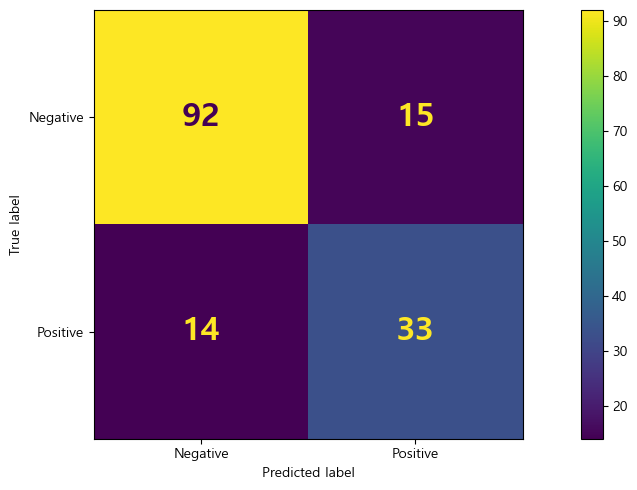


[변수 중요도]


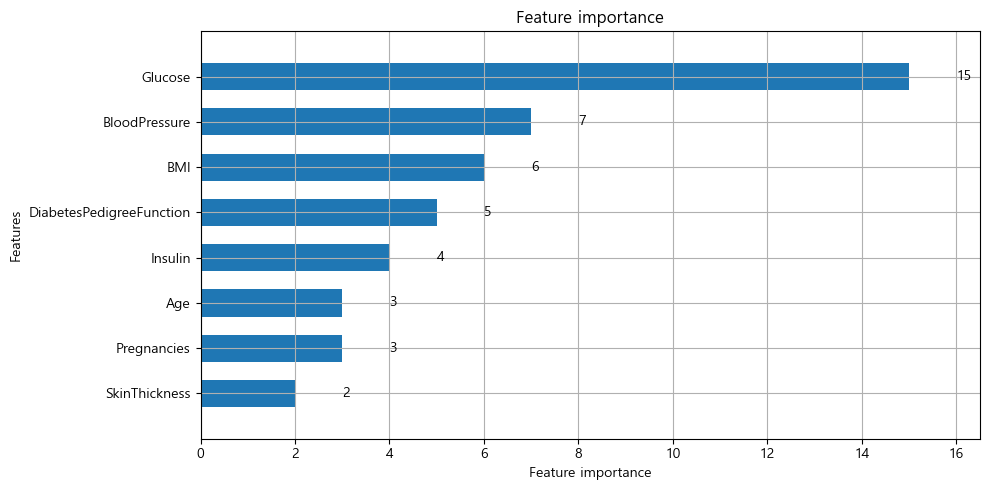

+--------------------------+---------+-----------+----------+
|                          |   score |      rate |   cumsum |
|--------------------------+---------+-----------+----------|
| Glucose                  |      15 |  0.333333 | 0.333333 |
| BloodPressure            |       7 |  0.155556 | 0.488889 |
| BMI                      |       6 |  0.133333 | 0.622222 |
| DiabetesPedigreeFunction |       5 |  0.111111 | 0.733333 |
| Insulin                  |       4 | 0.0888889 | 0.822222 |
| Pregnancies              |       3 | 0.0666667 | 0.888889 |
| Age                      |       3 | 0.0666667 | 0.955556 |
| SkinThickness            |       2 | 0.0444444 |        1 |
+--------------------------+---------+-----------+----------+

[Roc Curve]


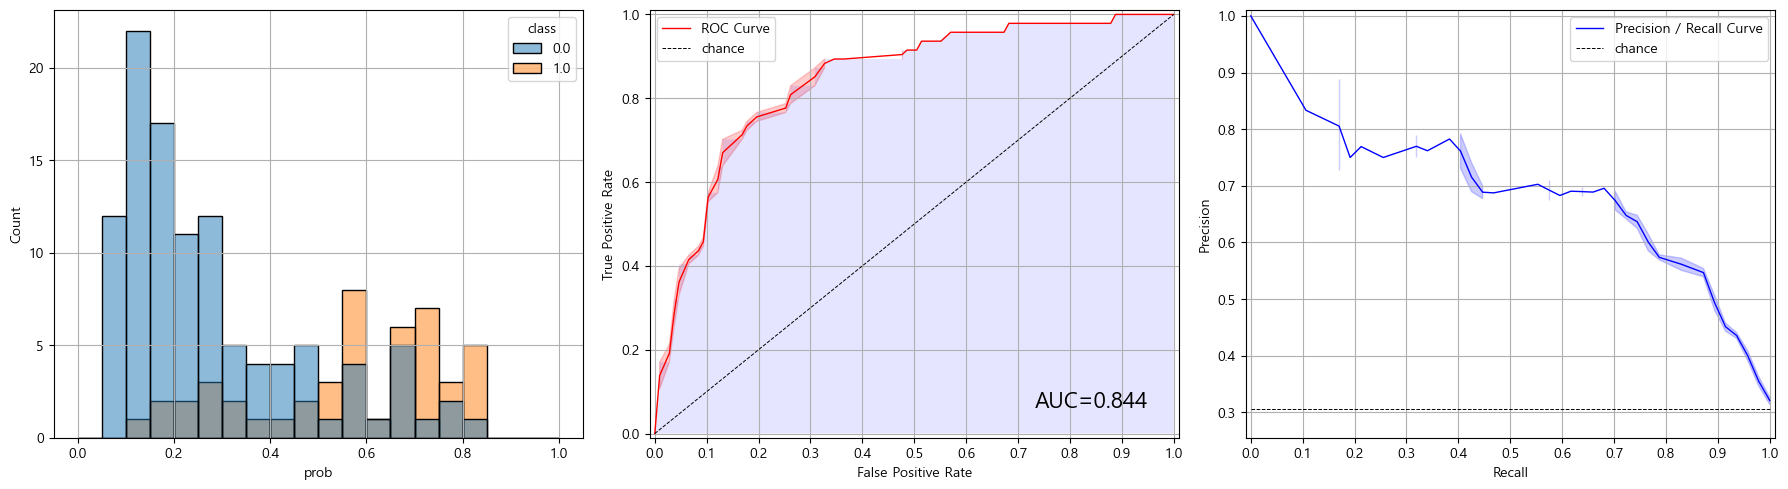


[학습곡선]


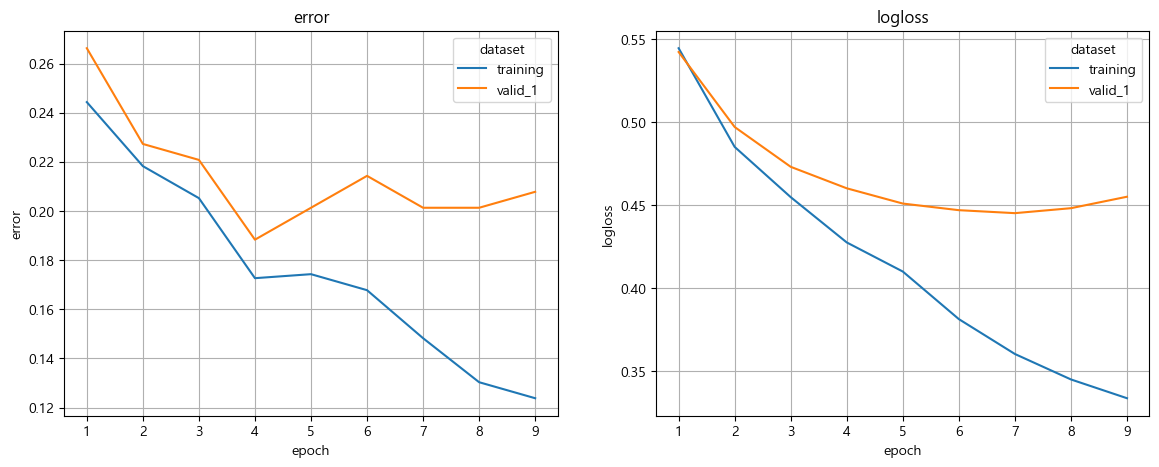

In [5]:
my_classification_result(estimator.best_estimator_, x_train, y_train, x_test, y_test)

### [4] 독립변수 보고


In [6]:
my_classification_report(estimator.best_estimator_, x_train, y_train, x_test, y_test)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+


### [5] 모듈화 기능 확인


[교차검증 TOP5]
+----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------+
|    |   subsample |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   lambda_l2 |   lambda_l1 |   colsample_bytree |   mean_test_score |
|----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------|
|  0 |         0.7 |            400 |                  9 |           4 |               1 |           7 |           7 |                0.8 |          0.760642 |
|  1 |         0.5 |            100 |                  7 |           2 |             0.1 |           0 |           3 |                0.7 |           0.75735 |
|  2 |         0.5 |            100 |                  1 |           0 |             0.5 |           3 |           1 |                0.7 |           0.75731 |
|  3 |           1 |        

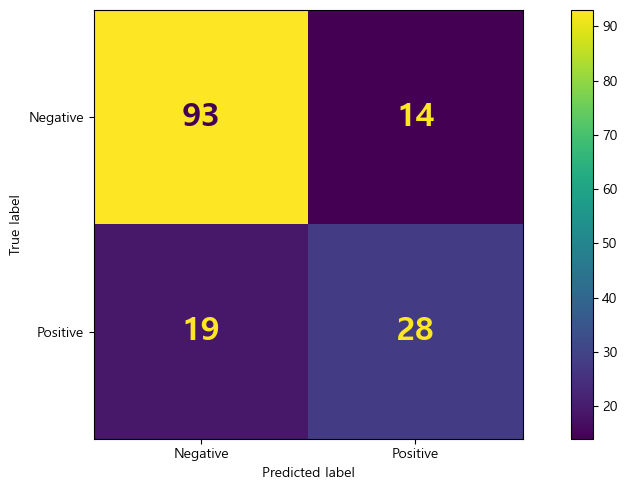


[변수 중요도]


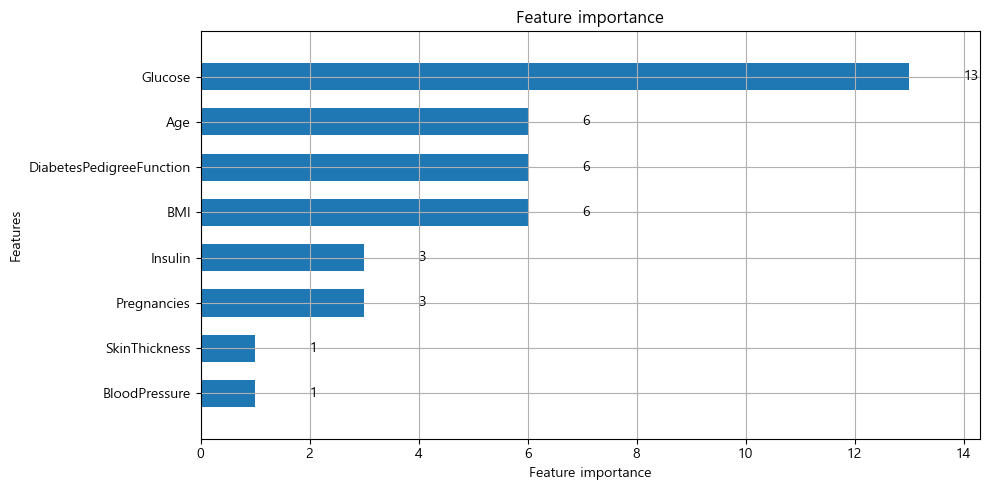

+--------------------------+---------+-----------+----------+
|                          |   score |      rate |   cumsum |
|--------------------------+---------+-----------+----------|
| Glucose                  |      13 |  0.333333 | 0.333333 |
| BMI                      |       6 |  0.153846 | 0.487179 |
| DiabetesPedigreeFunction |       6 |  0.153846 | 0.641026 |
| Age                      |       6 |  0.153846 | 0.794872 |
| Pregnancies              |       3 | 0.0769231 | 0.871795 |
| Insulin                  |       3 | 0.0769231 | 0.948718 |
| BloodPressure            |       1 |  0.025641 | 0.974359 |
| SkinThickness            |       1 |  0.025641 |        1 |
+--------------------------+---------+-----------+----------+

[Roc Curve]


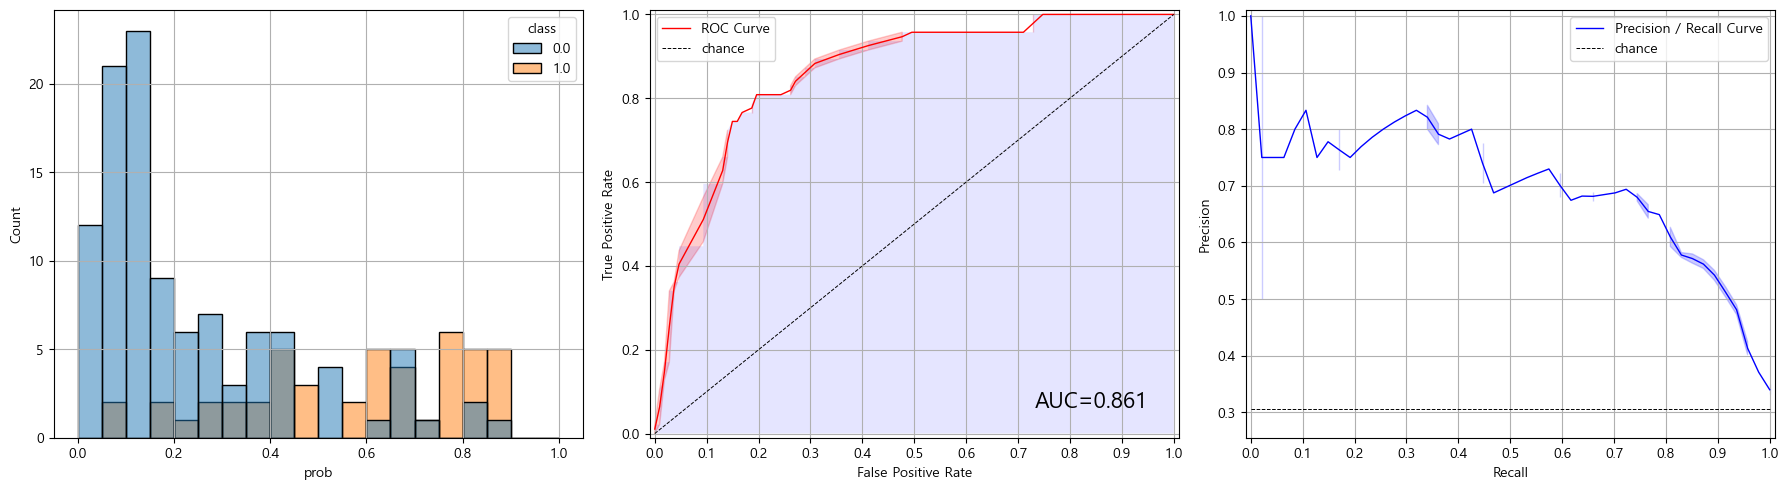


[학습곡선]


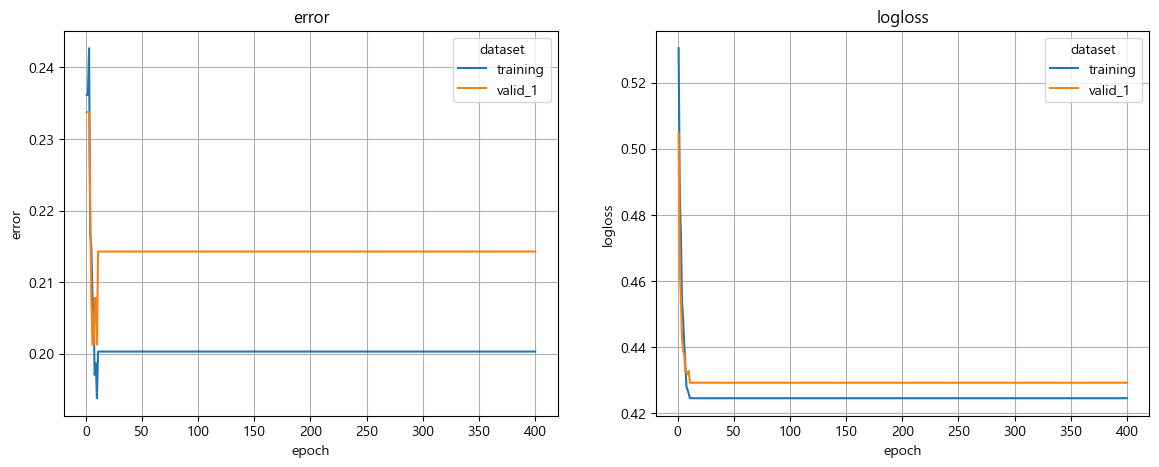

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 1.64872 |
|  1 |       3 | Outcome    | SkinThickness            |  1.5504 |
|  2 |       0 | Outcome    | Pregnancies              | 1.53706 |
|  3 |       5 | Outcome    | BMI                      | 1.52814 |
|  4 |       1 | Outcome    | Glucose                  | 1.33393 |
|  5 |       4 | Outcome    | Insulin                  | 1.28711 |
|  6 |       2 | Outcome    | BloodPressure            | 1.25589 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
+----+---------+------------+--------------------------+---------+


LGBMClassifier(colsample_bytree=0.8, device='cpu', lambda_l1=7, lambda_l2=7,
               learning_rate=1, max_depth=4, min_child_weight=9,
               n_estimators=400, n_jobs=-1, random_state=0, subsample=0.7,
               verbose=-1)

In [8]:
my_lgbm_classification(x_train, y_train, x_test, y_test)

## #03. 회귀분석

### [1] 데이터 가져오기


In [9]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)
x_train, x_test, y_train, y_test = my_train_test_split(origin, "MEDV", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

((404, 13), (102, 13), (404,), (102,))

### [2] 학습 모델 적합

#### (1) 하이퍼 파라미터 튜닝


In [10]:
estimator = LGBMRegressor(
    num_leaves=64,
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    early_stopping_rounds=5,
    verbose=-1,
)


params = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "min_child_weight": [1, 3, 5, 7, 9],
    "max_depth": [0, 2, 4, 6],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "lambda_l1": [0, 1, 3, 5, 7],
    "lambda_l2": [0, 1, 3, 5, 7],
}

estimator = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_jobs=get_n_jobs(),
    cv=5,
    random_state=get_random_state(),
)


estimator.fit(
    x_train,
    y_train,
    eval_metric="rmse",
    eval_set=[(x_train, y_train), (x_test, y_test)],
)

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(early_stopping_rounds=5, n_jobs=-1,
                                           num_leaves=64, random_state=0,
                                           verbose=-1),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'lambda_l1': [0, 1, 3, 5, 7],
                                        'lambda_l2': [0, 1, 3, 5, 7],
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7,
                                                          1],
                                        'max_depth': [0, 2, 4, 6],
                                        'min_child_weight': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.7, 1]},
                   random_state=0)

#### (2) RandomizedSearchCV 결과 확인


In [11]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

my_pretty_table(result_df.head(10))

+----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------+
|    |   subsample |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   lambda_l2 |   lambda_l1 |   colsample_bytree |   mean_test_score |
|----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------|
|  0 |         0.7 |            300 |                  9 |           0 |             0.1 |           7 |           0 |                0.7 |          0.875232 |
|  1 |         0.7 |            500 |                  5 |           4 |             0.5 |           3 |           1 |                0.8 |          0.862181 |
|  2 |         0.5 |            100 |                  1 |           0 |             0.5 |           3 |           1 |                0.7 |          0.859319 |
|  3 |         0.7 |            300 |   

### [3] 성능 평가


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.963502 |     0.694054 |
| 평균절대오차(MAE)             |      1.11423 |      2.83603 |
| 평균제곱오차(MSE)             |      3.10758 |      24.9127 |
| 평균오차(RMSE)                |      1.76283 |      4.99126 |
| 평균 절대 백분오차 비율(MAPE) |      5.67248 |      13.1317 |
| 평균 비율 오차(MPE)           |     -1.33843 |     -3.07173 |
+-------------------------------+--------------+--------------+

[학습곡선]


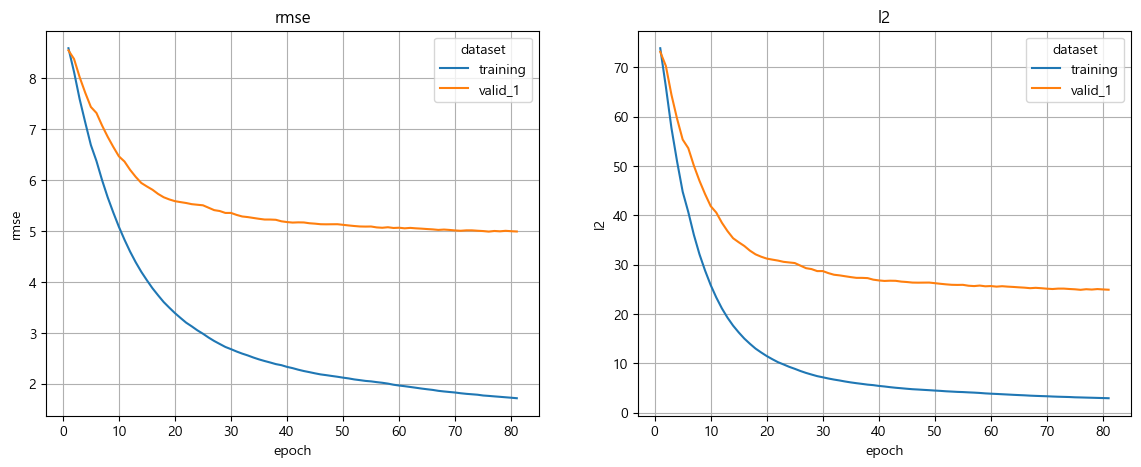


[변수 중요도]


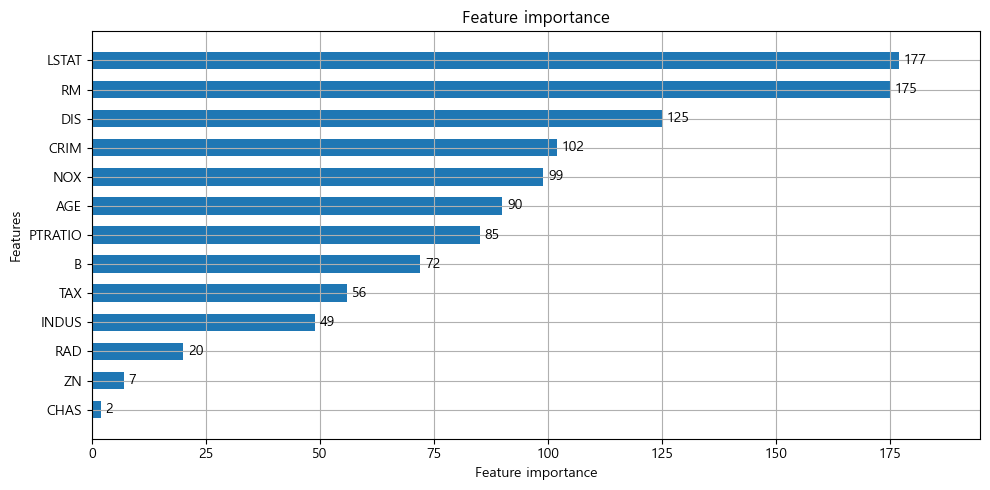

+---------+---------+------------+----------+
|         |   score |       rate |   cumsum |
|---------+---------+------------+----------|
| LSTAT   |     177 |   0.167139 | 0.167139 |
| RM      |     175 |    0.16525 | 0.332389 |
| DIS     |     125 |   0.118036 | 0.450425 |
| CRIM    |     102 |  0.0963173 | 0.546742 |
| NOX     |      99 |  0.0934844 | 0.640227 |
| AGE     |      90 |  0.0849858 | 0.725212 |
| PTRATIO |      85 |  0.0802644 | 0.805477 |
| B       |      72 |  0.0679887 | 0.873466 |
| TAX     |      56 |  0.0528801 | 0.926346 |
| INDUS   |      49 |  0.0462701 | 0.972616 |
| RAD     |      20 |  0.0188857 | 0.991501 |
| ZN      |       7 | 0.00661001 | 0.998111 |
| CHAS    |       2 | 0.00188857 |        1 |
+---------+---------+------------+----------+


In [12]:
my_regression_result(
    estimator=estimator.best_estimator_,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

### [4] 독립변수 보고


In [13]:
my_regression_report(estimator.best_estimator_, x_train, y_train, x_test, y_test)

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+



### [5] 모듈화 기능 확인


[교차검증 TOP5]
+----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------+
|    |   subsample |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   lambda_l2 |   lambda_l1 |   colsample_bytree |   mean_test_score |
|----+-------------+----------------+--------------------+-------------+-----------------+-------------+-------------+--------------------+-------------------|
|  0 |         0.7 |            300 |                  9 |           0 |             0.1 |           7 |           0 |                0.7 |          0.884238 |
|  1 |         0.5 |            100 |                  1 |           0 |             0.5 |           3 |           1 |                0.7 |          0.873017 |
|  2 |         0.7 |            500 |                  5 |           4 |             0.5 |           3 |           1 |                0.8 |          0.867382 |
|  3 |         0.7 |        

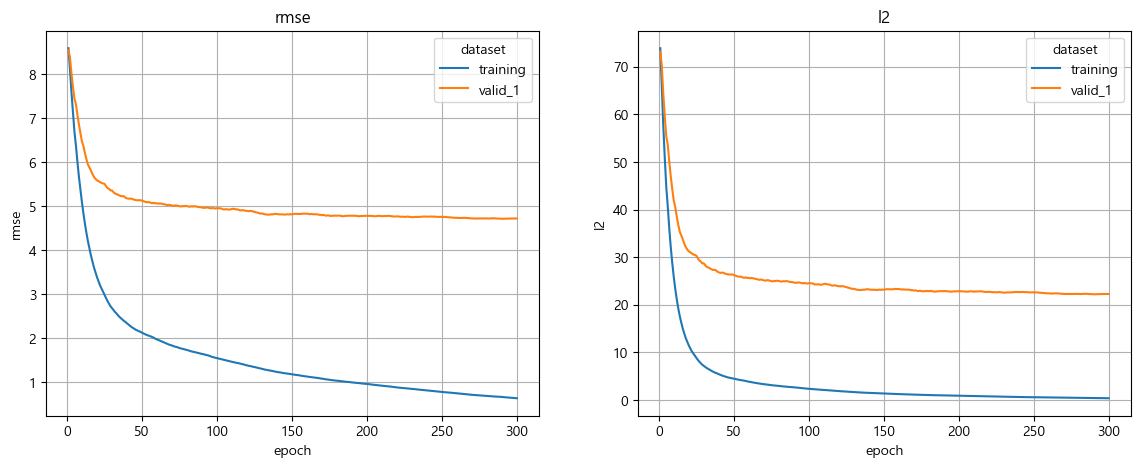


[변수 중요도]


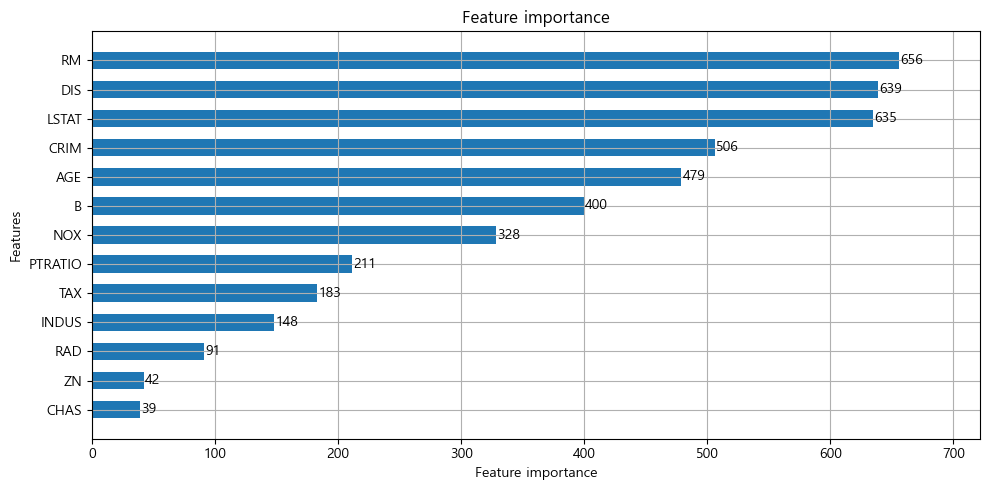

+---------+---------+------------+----------+
|         |   score |       rate |   cumsum |
|---------+---------+------------+----------|
| RM      |     656 |   0.150562 | 0.150562 |
| DIS     |     639 |   0.146661 | 0.297223 |
| LSTAT   |     635 |   0.145742 | 0.442965 |
| CRIM    |     506 |   0.116135 |   0.5591 |
| AGE     |     479 |   0.109938 | 0.669038 |
| B       |     400 |  0.0918063 | 0.760845 |
| NOX     |     328 |  0.0752812 | 0.836126 |
| PTRATIO |     211 |  0.0484278 | 0.884554 |
| TAX     |     183 |  0.0420014 | 0.926555 |
| INDUS   |     148 |  0.0339683 | 0.960523 |
| RAD     |      91 |  0.0208859 | 0.981409 |
| ZN      |      42 | 0.00963966 | 0.991049 |
| CHAS    |      39 | 0.00895111 |        1 |
+---------+---------+------------+----------+

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MED

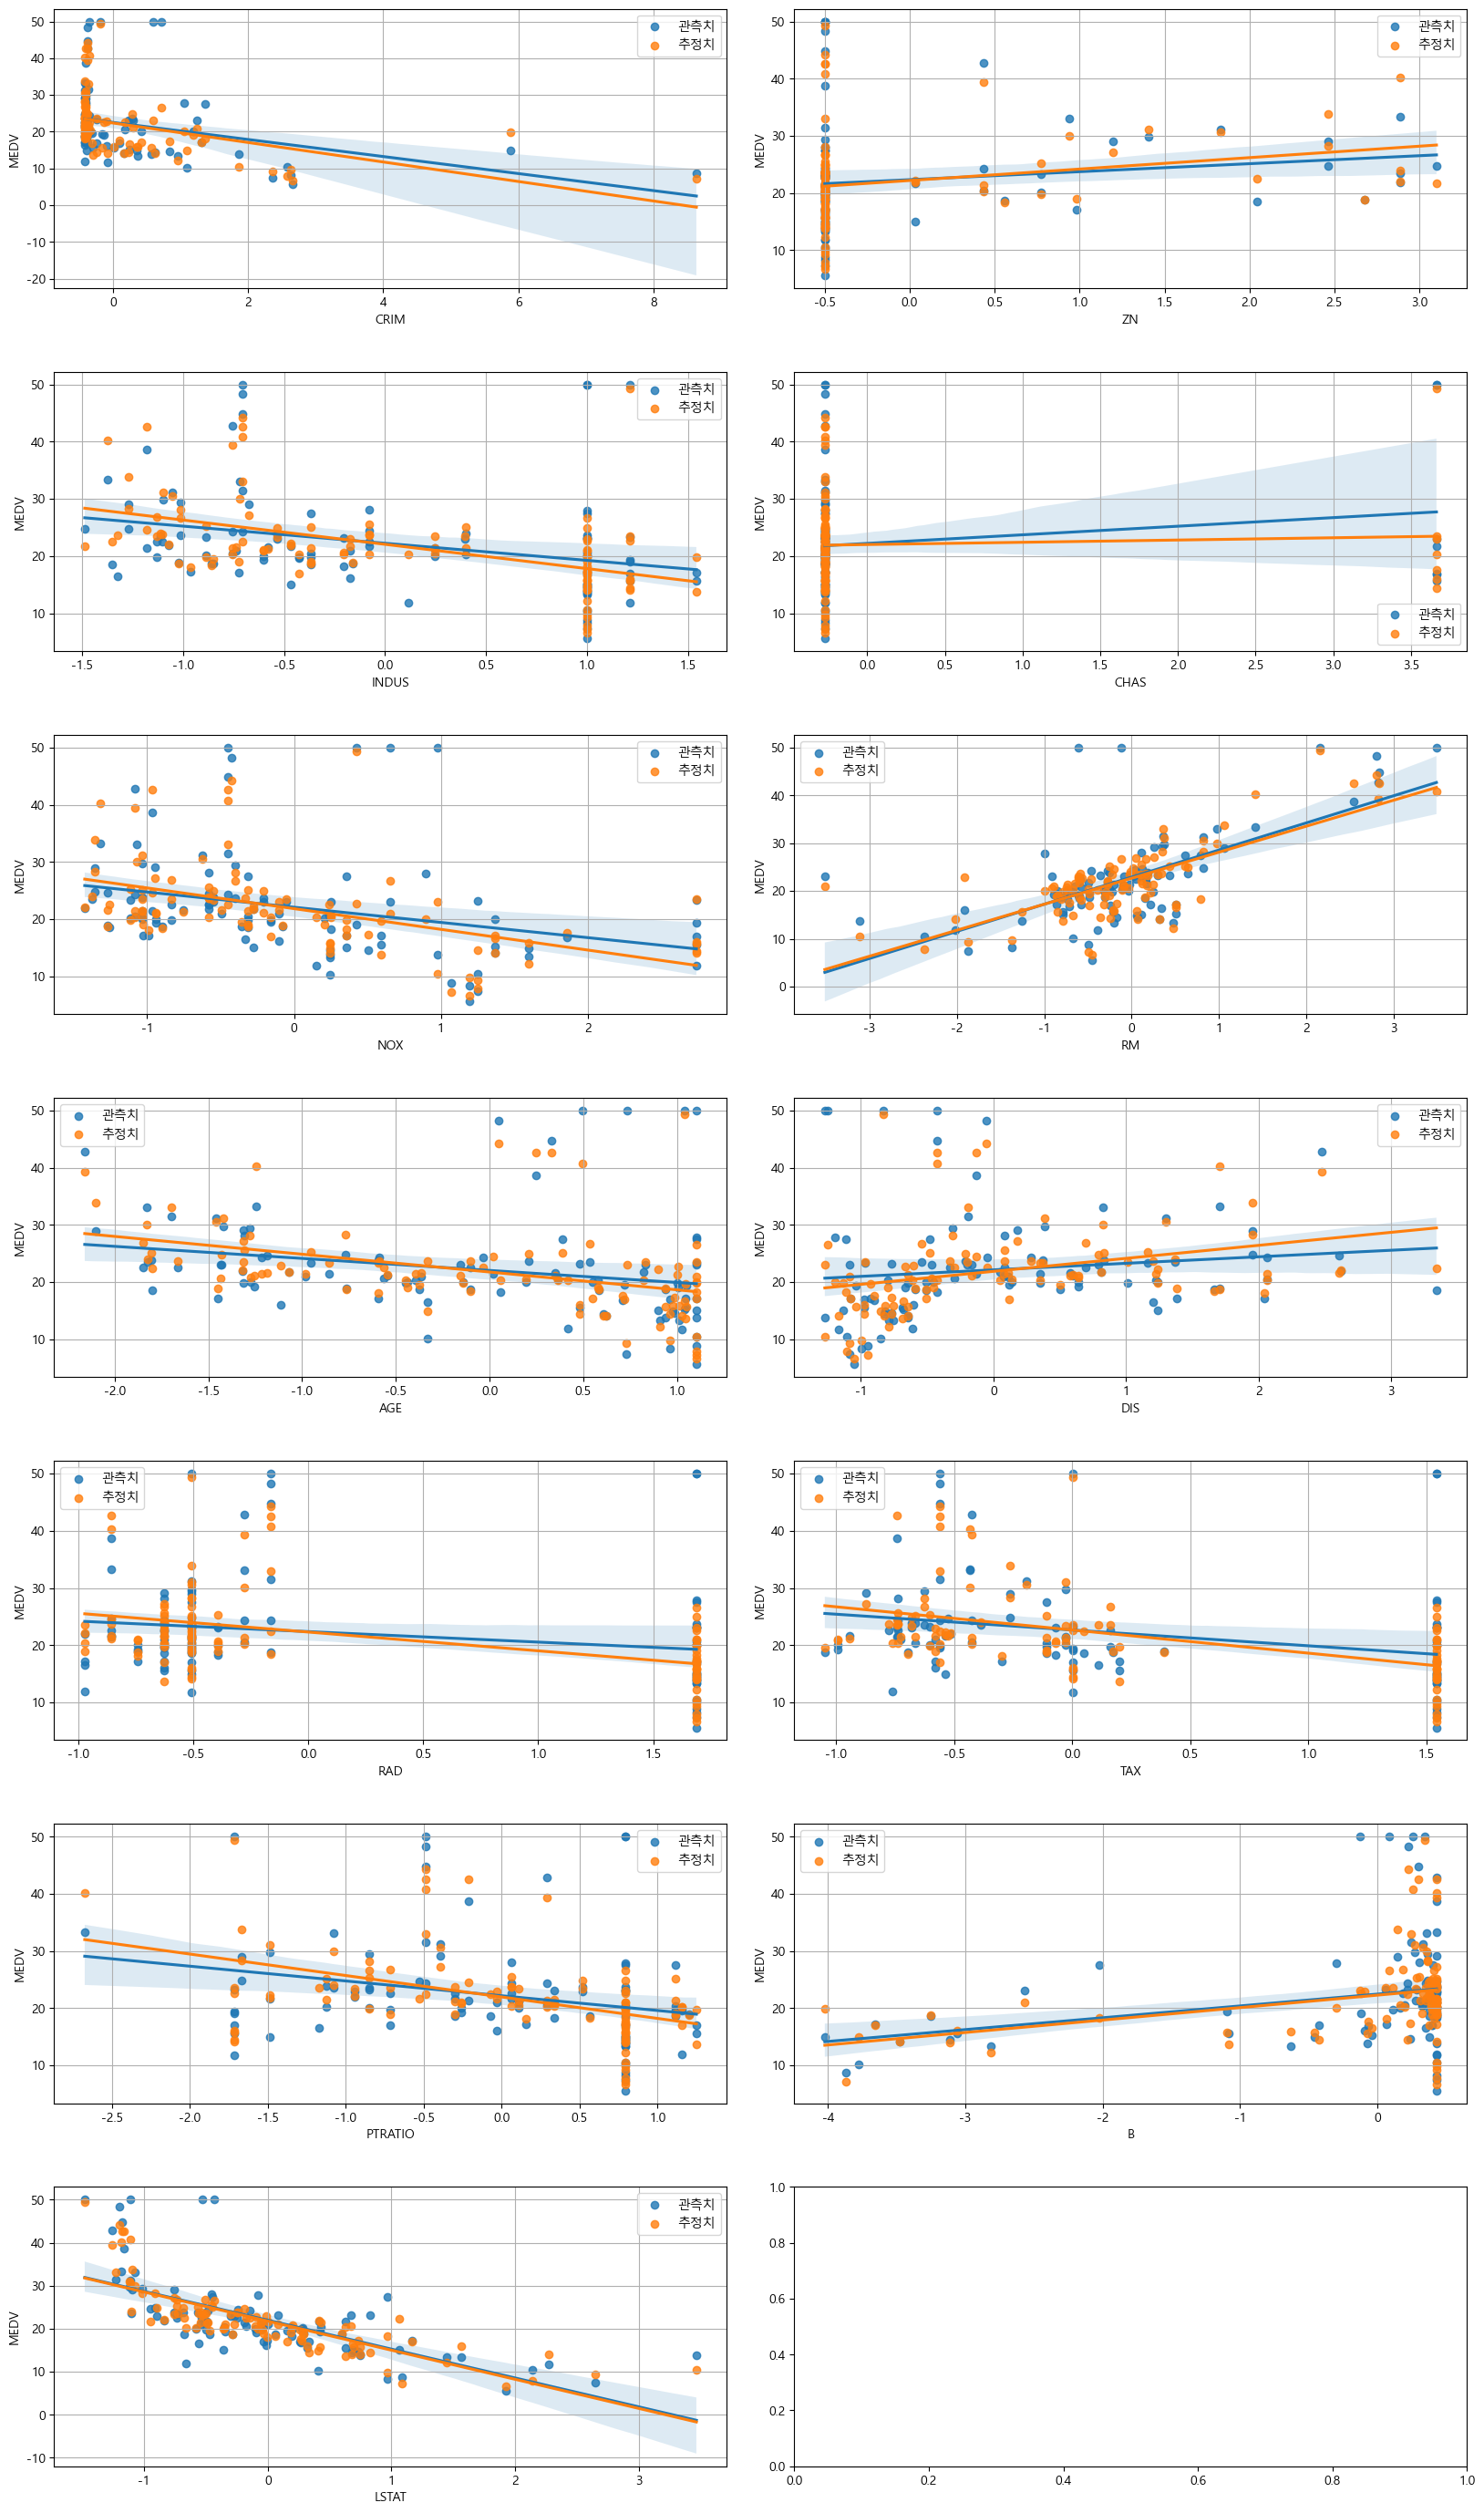

LGBMRegressor(colsample_bytree=0.7, device='cpu', lambda_l1=0, lambda_l2=7,
              max_depth=0, min_child_weight=9, n_estimators=300, n_jobs=-1,
              random_state=0, subsample=0.7, verbose=-1)

In [15]:
my_lgbm_regression(x_train, y_train, x_test, y_test, plot=True)